# 1D Wave Equation with Dirichlet boundary conditions

Let's solve this 1-dimensional wave equation:

```math
\begin{align*}
∂^2_t u(x, t) = c^2 ∂^2_x u(x, t) \quad & \textsf{for all } 0 < x < 1 \text{ and } t > 0 \, , \\
u(0, t) = u(1, t) = 0 \quad & \textsf{for all } t > 0 \, , \\
u(x, 0) = x (1-x)     \quad & \textsf{for all } 0 < x < 1 \, , \\
∂_t u(x, 0) = 0       \quad & \textsf{for all } 0 < x < 1 \, , \\
\end{align*}
```

with grid discretization `dx = 0.1` and physics-informed neural networks.

Further, the solution of this equation with the given boundary conditions is presented.


In [1]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL
using ModelingToolkit: Interval

@parameters t, x
@variables u(..)
Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dt = Differential(t)

#2D PDE
C = 1
eq = Dtt(u(t, x)) ~ C^2 * Dxx(u(t, x))

# Initial and boundary conditions
bcs = [u(t, 0) ~ 0.0,# for all t > 0
    u(t, 1) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x), #for all 0 < x < 1
    Dt(u(0, x)) ~ 0.0] #for all  0 < x < 1]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
    x ∈ Interval(0.0, 1.0)]
# Discretization
dx = 0.1

# Neural network
chain = Chain(Dense(2, 16, σ), Dense(16, 16, σ), Dense(16, 1))
discretization = PhysicsInformedNN(chain, GridTraining(dx))

@named pde_system = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])
prob = discretize(pde_system, discretization)

callback = function (p, l)
    println("Current loss is: $l")
    return false
end

# optimizer
opt = OptimizationOptimJL.BFGS()
res = Optimization.solve(prob, opt; callback, maxiters = 1200)
phi = discretization.phi

Current loss is: 0.2729354853096141
Current loss is: 0.025147071739778273
Current loss is: 0.02318852743400046
Current loss is: 0.021891120609401026
Current loss is: 0.02170748898892929
Current loss is: 0.02158354491668155
Current loss is: 0.021505969749505853
Current loss is: 0.02103369190022089
Current loss is: 0.020643326067872753
Current loss is: 0.020503598826311677
Current loss is: 0.020478487515019364
Current loss is: 0.020314399019890902
Current loss is: 0.02029641275638799
Current loss is: 0.020184207839473587
Current loss is: 0.020066333310829344
Current loss is: 0.019918040443930578
Current loss is: 0.01975112868453072
Current loss is: 0.019708128353004364
Current loss is: 0.019690464746800383
Current loss is: 0.019625103039327466
Current loss is: 0.018987986899493353
Current loss is: 0.018291209483372515
Current loss is: 0.017698402211535954
Current loss is: 0.017269075967893063
Current loss is: 0.01655500178633675
Current loss is: 0.01584379555625784
Current loss is: 0.015

NeuralPDE.Phi{StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Static.True, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static

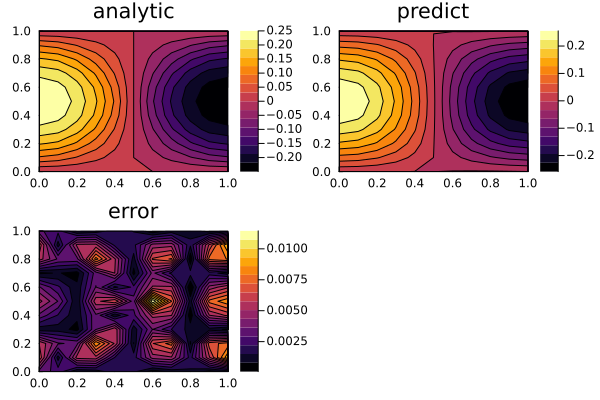

In [2]:
using Plots

ts, xs = [infimum(d.domain):dx:supremum(d.domain) for d in domains]
function analytic_sol_func(t, x)
    sum([(8 / (k^3 * pi^3)) * sin(k * pi * x) * cos(C * k * pi * t) for k in 1:2:50000])
end

u_predict = reshape([first(phi([t, x], res.u)) for t in ts for x in xs],
    (length(ts), length(xs)))
u_real = reshape([analytic_sol_func(t, x) for t in ts for x in xs],
    (length(ts), length(xs)))

diff_u = abs.(u_predict .- u_real)
p1 = plot(ts, xs, u_real, linetype = :contourf, title = "analytic");
p2 = plot(ts, xs, u_predict, linetype = :contourf, title = "predict");
p3 = plot(ts, xs, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)


## 1D Damped Wave Equation with Dirichlet boundary conditions

Now let's solve the 1-dimensional wave equation with damping.

```math
\begin{aligned}
\frac{\partial^2 u(t,x)}{\partial x^2} = \frac{1}{c^2} \frac{\partial^2 u(t,x)}{\partial t^2} + v \frac{\partial u(t,x)}{\partial t} \\
u(t, 0) = u(t, L) = 0 \\
u(0, x) = x(1-x) \\
u_t(0, x) = 1 - 2x \\
\end{aligned}
```

with grid discretization `dx = 0.05` and physics-informed neural networks. Here, we take advantage of adaptive derivative to increase accuracy.


┌ Info: Time 0.0...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.05...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.1...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.15...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.2...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.25...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.3...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.35...
└ @ Main /Users/reula/Julia/PINN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:94
┌ Info: Time 0.4...
└ @ Main

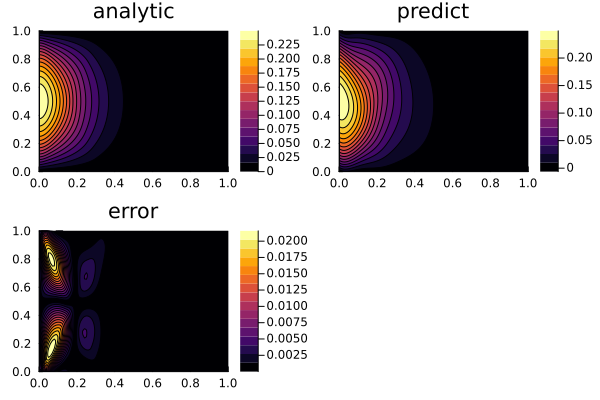

In [3]:
using NeuralPDE, Lux, ModelingToolkit, Optimization, OptimizationOptimJL
using Plots, Printf
using ModelingToolkit: Interval, infimum, supremum

@parameters t, x
@variables u(..) Dxu(..) Dtu(..) O1(..) O2(..)
Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dx = Differential(x)
Dt = Differential(t)

# Constants
v = 3
b = 2
L = 1.0
@assert b > 0 && b < 2π / (L * v)

# 1D damped wave
eq = Dx(Dxu(t, x)) ~ 1 / v^2 * Dt(Dtu(t, x)) + b * Dtu(t, x)

# Initial and boundary conditions
bcs_ = [u(t, 0) ~ 0.0,# for all t > 0
    u(t, L) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x), # for all 0 < x < 1
    Dtu(0, x) ~ 1 - 2x # for all  0 < x < 1
]

ep = (cbrt(eps(eltype(Float64))))^2 / 6

der = [Dxu(t, x) ~ Dx(u(t, x)) + ep * O1(t, x),
    Dtu(t, x) ~ Dt(u(t, x)) + ep * O2(t, x)]

bcs = [bcs_; der]

# Space and time domains
domains = [t ∈ Interval(0.0, L),
    x ∈ Interval(0.0, L)]

# Neural network
inn = 25
innd = 4
chain = [[Chain(Dense(2, inn, tanh),
              Dense(inn, inn, tanh),
              Dense(inn, inn, tanh),
              Dense(inn, 1)) for _ in 1:3]
         [Chain(Dense(2, innd, tanh), Dense(innd, 1)) for _ in 1:2]]

strategy = GridTraining(0.02)
discretization = PhysicsInformedNN(chain, strategy;)

@named pde_system = PDESystem(eq, bcs, domains, [t, x],
    [u(t, x), Dxu(t, x), Dtu(t, x), O1(t, x), O2(t, x)])
prob = discretize(pde_system, discretization)
sym_prob = NeuralPDE.symbolic_discretize(pde_system, discretization)

pde_inner_loss_functions = sym_prob.loss_functions.pde_loss_functions
bcs_inner_loss_functions = sym_prob.loss_functions.bc_loss_functions

callback = function (p, l)
    println("loss: ", l)
    println("pde_losses: ", map(l_ -> l_(p.u), pde_inner_loss_functions))
    println("bcs_losses: ", map(l_ -> l_(p.u), bcs_inner_loss_functions))
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters = 2000)
prob = remake(prob, u0 = res.u)
res = Optimization.solve(prob, BFGS(); maxiters = 2000)

phi = discretization.phi[1]

# Analysis
ts, xs = [infimum(d.domain):0.05:supremum(d.domain) for d in domains]

μ_n(k) = (v * sqrt(4 * k^2 * π^2 - b^2 * L^2 * v^2)) / (2 * L)
function b_n(k)
    2 / L * -(L^2 *
      ((2 * π * L - π) * k * sin(π * k) + ((π^2 - π^2 * L) * k^2 + 2 * L) * cos(π * k) -
       2 * L)) / (π^3 * k^3)
end # vegas((x, ϕ) -> ϕ[1] = sin(k * π * x[1]) * f(x[1])).integral[1]
function a_n(k)
    2 / -(L * μ_n(k)) * (L * (((2 * π * L^2 - π * L) * b * k * sin(π * k) +
       ((π^2 * L - π^2 * L^2) * b * k^2 + 2 * L^2 * b) * cos(π * k) - 2 * L^2 * b) * v^2 +
      4 * π * L * k * sin(π * k) + (2 * π^2 - 4 * π^2 * L) * k^2 * cos(π * k) -
      2 * π^2 * k^2)) / (2 * π^3 * k^3)
end

# Plot
function analytic_sol_func(t, x)
    sum([sin((k * π * x) / L) * exp(-v^2 * b * t / 2) *
         (a_n(k) * sin(μ_n(k) * t) + b_n(k) * cos(μ_n(k) * t)) for k in 1:2:100])
end # TODO replace 10 with 500
anim = @animate for t in ts
    @info "Time $t..."
    sol = [analytic_sol_func(t, x) for x in xs]
    sol_p = [first(phi([t, x], res.u.depvar.u)) for x in xs]
    plot(sol, label = "analytic", ylims = [0, 0.1])
    title = @sprintf("t = %.3f", t)
    plot!(sol_p, label = "predict", ylims = [0, 0.1], title = title)
end
gif(anim, "1Dwave_damped_adaptive.gif", fps = 200)

# Surface plot
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in domains]
u_predict = reshape(
    [first(phi([t, x], res.u.depvar.u)) for
     t in ts for x in xs], (length(ts), length(xs)))
u_real = reshape([analytic_sol_func(t, x) for t in ts for x in xs],
    (length(ts), length(xs)))

diff_u = abs.(u_predict .- u_real)
p1 = plot(ts, xs, u_real, linetype = :contourf, title = "analytic");
p2 = plot(ts, xs, u_predict, linetype = :contourf, title = "predict");
p3 = plot(ts, xs, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)